In [ ]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from kmeans import KMeans
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import cv2
import pandas as pd
from collections import Counter
from IPython.display import display



# Introduction

In [ ]:
# Directory di Chiara
#TRAIN_DATASET_PATH = "/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

#Directory di Gianluca
TRAIN_DATASET_PATH= "C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Carica il file .nii come array NumPy
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()

# Stampa informazioni sull'immagine
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

# Data Visualization

In [ ]:
# Rescaling voxel-wise a [0, 1]
test_image_flair = (test_image_flair - np.min(test_image_flair)) / (np.max(test_image_flair) - np.min(test_image_flair))

# Verifica
print("Rescaled min:", test_image_flair.min())
print("Rescaled max:", test_image_flair.max())

In [ ]:
# Carica il file .nii come array NumPy
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
# Rescaling voxel-wise a [0, 1]
test_image_t1 = (test_image_t1 - np.min(test_image_t1)) / (np.max(test_image_t1) - np.min(test_image_t1))

# Carica il file .nii come array NumPy
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
# Rescaling voxel-wise a [0, 1]
test_image_t1ce = (test_image_t1ce - np.min(test_image_t1ce)) / (np.max(test_image_t1ce) - np.min(test_image_t1ce))

# Carica il file .nii come array NumPy
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
# Rescaling voxel-wise a [0, 1]
test_image_t2 = (test_image_t2 - np.min(test_image_t2)) / (np.max(test_image_t2) - np.min(test_image_t2))

test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()


In [ ]:
# === Colori per la maschera ===
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap_mask = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], cmap_mask.N)

# === Visualizzazione dinamica ===
def show_slice(slice_idx):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # MRI modalities
    titles = ['T1', 'T1ce', 'T2', 'FLAIR']
    volumes = [test_image_t1, test_image_t1ce, test_image_t2, test_image_flair]

    for i in range(4):
        axs[i // 3, i % 3].imshow(volumes[i][:, :, slice_idx], cmap='gray')
        axs[i // 3, i % 3].set_title(titles[i])
        axs[i // 3, i % 3].axis('off')

    # Mask
    axs[1, 1].imshow(test_image_seg[:, :, slice_idx], cmap=cmap_mask, norm=norm)
    axs[1, 1].set_title('Mask')
    axs[1, 1].axis('off')

    # Legend
    axs[1, 2].axis('off')
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
    axs[1, 2].legend(handles=patches, loc='center')

    plt.tight_layout()
    plt.show()

# === Interfaccia interattiva ===
interact(
    show_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_t1.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

In [ ]:
# === Funzione per visualizzare le tre viste ===
def show_views(slice_idx):
    fig = plt.figure(figsize=(12, 5))
    
    # Transverse View (axial): [x, y, slice]
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(test_image_t1ce[:, :, slice_idx], cmap='gray')
    ax1.set_title(f'T1 - Transverse View (Z={slice_idx})')
    ax1.axis('off')
    
    # Frontal View (coronal): [x, slice, z] → rotate for readability
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(rotate(test_image_t1ce[:, slice_idx, :], 90, reshape=True), cmap='gray')
    ax2.set_title(f'T1 - Frontal View (Y={slice_idx})')
    ax2.axis('off')
    
    # Sagittal View: [slice, y, z] → rotate for readability
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(rotate(test_image_t1ce[slice_idx, :, :], 90, reshape=True), cmap='gray')
    ax3.set_title(f'T1 - Sagittal View (X={slice_idx})')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# === Slider interattivo ===
# Usa la dimensione più piccola per non eccedere l'indice valido in nessuna direzione
max_index = min(test_image_t1ce.shape)

interact(
    show_views,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=max_index - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

In [ ]:
# === Mappa colori e normalizzazione (adatta a BraTS ad esempio)
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR/NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], len(colors))

# === Funzione dinamica
def show_segmented_slice(slice_idx):
    # Isola ogni classe come maschera separata (usando NaN per trasparenza)
    seg_0 = test_image_seg.copy()
    seg_0[seg_0 != 0] = np.nan
    
    seg_1 = test_image_seg.copy()
    seg_1[seg_1 != 1] = np.nan
    
    seg_2 = test_image_seg.copy()
    seg_2[seg_2 != 2] = np.nan
    
    seg_4 = test_image_seg.copy()
    seg_4[seg_4 != 4] = np.nan

    # Legenda personalizzata
    legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

    # Plot
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].imshow(test_image_seg[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[0].set_title('Original Segmentation')
    ax[0].legend(handles=legend, loc='lower left')
    ax[0].axis('off')

    ax[1].imshow(seg_0[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[1].set_title('Class 0 (Background)')
    ax[1].axis('off')

    ax[2].imshow(seg_1[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[2].set_title('Class 1 (NCR/NET)')
    ax[2].axis('off')

    ax[3].imshow(seg_2[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[3].set_title('Class 2 (Edema)')
    ax[3].axis('off')

    ax[4].imshow(seg_4[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[4].set_title('Class 4 (Enhancing Tumor)')
    ax[4].axis('off')

    plt.tight_layout()
    plt.show()

# === Slider interattivo
interact(
    show_segmented_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_seg.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

# K-Means

In [ ]:

#Parametri
slice_idx = 95
k = 5  # Numero di cluster per K-Means
 
#Slice delle differenti modalità
flair_slice = test_image_flair[:, :, slice_idx]
t1_slice = test_image_t1[:, :, slice_idx]
t1ce_slice = test_image_t1ce[:, :, slice_idx]
t2_slice = test_image_t2[:, :, slice_idx]
mask_slice = test_image_seg[:, :, slice_idx]
 
# Le slice vengono congiunte attraverso il metodo stack, che unisce più array lungo una
# nuova dimensione. Con un reshape, ogni pixel viene rappresentato da un vettore di 4 valori (uno per ogni modalità)

X = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=-1) 
print("Shape of X:", X.shape)
X_reshaped = X.reshape((-1, 4)).astype(np.float32) #240x240 e poi si tiene la dimensione 4, KMeans lavora su un array 2D
print("Shape of X_reshaped:", X_reshaped.shape)

# === Applica K-Means ===
km = KMeans(n_clus=k)
km.fit(X_reshaped)
clusters = km.getClusters()
 
# Ritorniamo alla dimensione 240x240
segmented_image = clusters.reshape(flair_slice.shape) 
 
# Colori clusters
cmap_kmeans = ListedColormap(['black', 'blue', 'green', 'yellow', 'lightblue'])
 
# Colori maschera
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap_mask = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], cmap_mask.N)
 
# === Visualizzazione ===
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
axs[0].imshow(segmented_image, cmap=cmap_kmeans)
axs[0].set_title(f'K-Means (k={k}) - Slice {slice_idx}')
axs[0].axis('off')
 
axs[1].imshow(mask_slice, cmap=cmap_mask, norm=norm)
axs[1].set_title('Ground Truth (BraTS Segmentation)')
axs[1].axis('off')
 
# Legenda della maschera reale
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
axs[1].legend(handles=patches, loc='lower left', bbox_to_anchor=(1.05, 0))
 
plt.tight_layout()
plt.show()

In [ ]:
def map_clusters_to_classes(cluster_labels, true_labels):
    """
    Maps K-Means cluster labels to ground truth classes using class prevalence
    
    Args:
        cluster_labels (np.ndarray): Predicted cluster indices (H, W)
        true_labels (np.ndarray): Ground truth segmentation (H, W)
    
    Returns:
        tuple: (mapped_labels, true_seg_processed) 
    """
    # Preprocess ground truth: map 4→3 (enhancing tumor)
    true_seg_processed = true_labels.copy()
    true_seg_processed[true_seg_processed == 4] = 3
    
    mapped_labels = np.zeros_like(cluster_labels)
    unique_clusters = np.unique(cluster_labels)
    
    # Calculate class distribution in ground truth
    class_distribution = Counter(true_seg_processed.flatten())
    
    for cluster in unique_clusters:
        mask = (cluster_labels == cluster)
        true_pixels = true_seg_processed[mask]
        
        # Get non-background pixels
        non_bg_pixels = true_pixels[true_pixels != 0]
        
        if len(non_bg_pixels) > 0:
            # Find most frequent non-background class
            class_counts = Counter(non_bg_pixels)
            mapped_class = class_counts.most_common(1)[0][0]
        else:
            # If only background, use most frequent class overall
            mapped_class = class_distribution.most_common(1)[0][0]
        
        mapped_labels[mask] = mapped_class
    
    return mapped_labels, true_seg_processed

def compute_kmeans_metrics(patient_id, slice_idx, k=4):
    """Computes segmentation metrics for K-Means on a given slice"""
    # Load and preprocess data
    case_path = os.path.join(TRAIN_DATASET_PATH, patient_id)
    
    # Load all modalities
    flair = nib.load(os.path.join(case_path, f"{patient_id}_flair.nii")).get_fdata()[:, :, slice_idx]
    t1 = nib.load(os.path.join(case_path, f"{patient_id}_t1.nii")).get_fdata()[:, :, slice_idx]
    t1ce = nib.load(os.path.join(case_path, f"{patient_id}_t1ce.nii")).get_fdata()[:, :, slice_idx]
    t2 = nib.load(os.path.join(case_path, f"{patient_id}_t2.nii")).get_fdata()[:, :, slice_idx]
    seg = nib.load(os.path.join(case_path, f"{patient_id}_seg.nii")).get_fdata()[:, :, slice_idx]
    
    # Rescale each modality
    flair = (flair - np.min(flair)) / (np.max(flair) - np.min(flair))
    t1 = (t1 - np.min(t1)) / (np.max(t1) - np.min(t1))
    t1ce = (t1ce - np.min(t1ce)) / (np.max(t1ce) - np.min(t1ce))
    t2 = (t2 - np.min(t2)) / (np.max(t2) - np.min(t2))
    
    # Prepare input data
    X = np.stack([flair, t1, t1ce, t2], axis=-1)
    X_reshaped = X.reshape((-1, 4))
    
    # Apply K-Means
    km = KMeans(n_clus=k)
    km.fit(X_reshaped.astype(np.float32))
    clusters = km.getClusters().reshape(flair.shape)
    
    # Map clusters to classes
    mapped_seg, true_seg = map_clusters_to_classes(clusters, seg)
    
    # Compute metrics
    metrics = {}
    class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
    
    for class_id, class_name in enumerate(class_names):
        true_mask = (true_seg == class_id)
        pred_mask = (mapped_seg == class_id)
        
        # Dice Coefficient
        intersection = np.logical_and(true_mask, pred_mask).sum()
        dice = (2. * intersection) / (true_mask.sum() + pred_mask.sum() + 1e-7)
        
        # Sensitivity (Recall)
        tp = np.logical_and(true_mask, pred_mask).sum()
        fn = np.logical_and(true_mask, ~pred_mask).sum()
        sensitivity = tp / (tp + fn + 1e-7)
        
        # Precision
        fp = np.logical_and(~true_mask, pred_mask).sum()
        precision = tp / (tp + fp + 1e-7)
        
        metrics[class_name] = {
            'dice': dice,
            'sensitivity': sensitivity,
            'precision': precision
        }
    
    # Return all necessary data including the FLAIR image for visualization
    return metrics, clusters, mapped_seg, true_seg, flair

# Example usage for patient 355, slice 95
patient_id = "BraTS20_Training_355"
slice_idx = 95

# Compute metrics and get results
metrics, clusters, mapped_seg, true_seg, flair_img = compute_kmeans_metrics(patient_id, slice_idx)

# Print metrics
print("K-Means Evaluation Metrics:")
for class_name, scores in metrics.items():
    print(f"{class_name}:")
    print(f"  Dice = {scores['dice']:.4f}")
    print(f"  Sensitivity = {scores['sensitivity']:.4f}")
    print(f"  Precision = {scores['precision']:.4f}\n")

# Visual comparison
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Original MRI (FLAIR)
axs[0].imshow(flair_img, cmap="gray")
axs[0].set_title('FLAIR Image')
axs[0].axis('off')

# K-Means clusters
axs[1].imshow(clusters, cmap="viridis")
axs[1].set_title('K-Means Clusters')
axs[1].axis('off')

# Mapped segmentation
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
cmap_mapped = ListedColormap(colors)
axs[2].imshow(mapped_seg, cmap=cmap_mapped, 
              norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[2].set_title('Mapped Segmentation')
axs[2].axis('off')

# Ground Truth
axs[3].imshow(true_seg, cmap=cmap_mapped, 
             norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[3].set_title('Ground Truth')
axs[3].axis('off')

# Add legend
patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(4)]
plt.figlegend(patches, class_names, loc='lower center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for legend
plt.show()

# Non-Negative Matrix Factorization

NMF Evaluation Metrics:
Background:
  Dice = 0.0000
  Sensitivity = 0.0000
  Precision = 0.0000

Necrotic/Core:
  Dice = 0.0000
  Sensitivity = 0.0000
  Precision = 0.0000

Edema:
  Dice = 0.0492
  Sensitivity = 0.9941
  Precision = 0.0252

Enhancing:
  Dice = 0.2403
  Sensitivity = 0.8020
  Precision = 0.1413



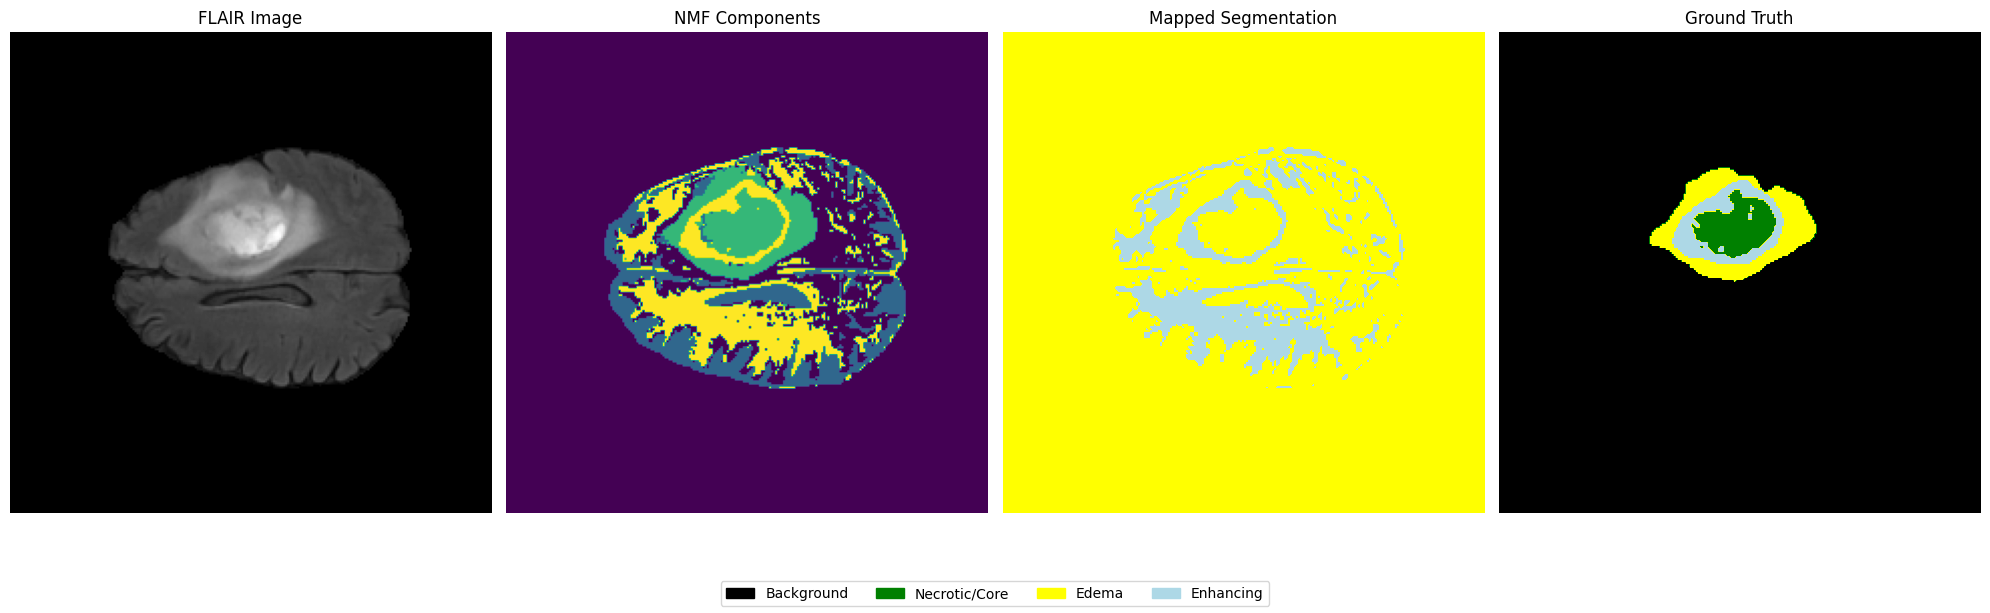

In [ ]:
from sklearn.decomposition import NMF

def map_nmf_to_classes(component_labels, true_labels):
    """
    Maps NMF component labels to ground truth classes using class prevalence
    """
    # Preprocess ground truth: map 4→3 (enhancing tumor)
    true_seg_processed = true_labels.copy()
    true_seg_processed[true_seg_processed == 4] = 3
    
    mapped_labels = np.zeros_like(component_labels)
    unique_comps = np.unique(component_labels)
    
    # Calculate class distribution in ground truth
    class_distribution = Counter(true_seg_processed.flatten())
    
    for comp in unique_comps:
        mask = (component_labels == comp)
        true_pixels = true_seg_processed[mask]
        
        # Get non-background pixels
        non_bg_pixels = true_pixels[true_pixels != 0]
        
        if len(non_bg_pixels) > 0:
            # Find most frequent non-background class
            class_counts = Counter(non_bg_pixels)
            mapped_class = class_counts.most_common(1)[0][0]
        else:
            # If only background, use most frequent class overall
            mapped_class = class_distribution.most_common(1)[0][0]
        
        mapped_labels[mask] = mapped_class
    
    return mapped_labels, true_seg_processed

def compute_nmf_metrics(patient_id, slice_idx, n_components=4):
    """Computes segmentation metrics for NMF on a given slice"""
    # Load and preprocess data
    case_path = os.path.join(TRAIN_DATASET_PATH, patient_id)
    
    # Load all modalities
    flair = nib.load(os.path.join(case_path, f"{patient_id}_flair.nii")).get_fdata()[:, :, slice_idx]
    t1 = nib.load(os.path.join(case_path, f"{patient_id}_t1.nii")).get_fdata()[:, :, slice_idx]
    t1ce = nib.load(os.path.join(case_path, f"{patient_id}_t1ce.nii")).get_fdata()[:, :, slice_idx]
    t2 = nib.load(os.path.join(case_path, f"{patient_id}_t2.nii")).get_fdata()[:, :, slice_idx]
    seg = nib.load(os.path.join(case_path, f"{patient_id}_seg.nii")).get_fdata()[:, :, slice_idx]
    
    # Rescale each modality
    flair = (flair - np.min(flair)) / (np.max(flair) - np.min(flair) + 1e-7)
    t1 = (t1 - np.min(t1)) / (np.max(t1) - np.min(t1) + 1e-7)
    t1ce = (t1ce - np.min(t1ce)) / (np.max(t1ce) - np.min(t1ce) + 1e-7)
    t2 = (t2 - np.min(t2)) / (np.max(t2) - np.min(t2) + 1e-7)
    
    # Prepare input data
    X = np.stack([flair, t1, t1ce, t2], axis=-1)
    X_reshaped = X.reshape((-1, 4))
    
    # Apply NMF
    nmf_model = NMF(n_components=n_components, init='nndsvda', max_iter=200, random_state=42)
    W = nmf_model.fit_transform(np.maximum(X_reshaped, 0))
    components = np.argmax(W, axis=1).reshape(flair.shape)
    
    # Map components to classes
    mapped_seg, true_seg = map_nmf_to_classes(components, seg)
    
    # Compute metrics
    metrics = {}
    class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
    
    for class_id, class_name in enumerate(class_names):
        true_mask = (true_seg == class_id)
        pred_mask = (mapped_seg == class_id)
        
        # Dice Coefficient
        intersection = np.logical_and(true_mask, pred_mask).sum()
        dice = (2. * intersection) / (true_mask.sum() + pred_mask.sum() + 1e-7)
        
        # Sensitivity (Recall)
        tp = np.logical_and(true_mask, pred_mask).sum()
        fn = np.logical_and(true_mask, ~pred_mask).sum()
        sensitivity = tp / (tp + fn + 1e-7)
        
        # Precision
        fp = np.logical_and(~true_mask, pred_mask).sum()
        precision = tp / (tp + fp + 1e-7)
        
        metrics[class_name] = {
            'dice': dice,
            'sensitivity': sensitivity,
            'precision': precision
        }
    
    # Return all necessary data including the FLAIR image for visualization
    return metrics, components, mapped_seg, true_seg, flair

# Example usage for patient 355, slice 95
patient_id = "BraTS20_Training_355"
slice_idx = 95

# Compute metrics and get results
metrics, components, mapped_seg, true_seg, flair_img = compute_nmf_metrics(patient_id, slice_idx)

# Print metrics
print("NMF Evaluation Metrics:")
for class_name, scores in metrics.items():
    print(f"{class_name}:")
    print(f"  Dice = {scores['dice']:.4f}")
    print(f"  Sensitivity = {scores['sensitivity']:.4f}")
    print(f"  Precision = {scores['precision']:.4f}\n")

# Visual comparison
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Original MRI (FLAIR)
axs[0].imshow(flair_img, cmap="gray")
axs[0].set_title('FLAIR Image')
axs[0].axis('off')

# NMF components
axs[1].imshow(components, cmap="viridis")
axs[1].set_title('NMF Components')
axs[1].axis('off')

# Mapped segmentation
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background', 'Necrotic/Core', 'Edema', 'Enhancing']
cmap_mapped = ListedColormap(colors)
axs[2].imshow(mapped_seg, cmap=cmap_mapped, 
              norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[2].set_title('Mapped Segmentation')
axs[2].axis('off')

# Ground Truth
axs[3].imshow(true_seg, cmap=cmap_mapped, 
              norm=BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], 4))
axs[3].set_title('Ground Truth')
axs[3].axis('off')

# Add legend
patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(4)]
plt.figlegend(patches, class_names, loc='lower center', ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for legend
plt.show()


# Data Splitting

In [ ]:
# Ottieni la lista degli ID (ultime parti dei path delle directory)
train_and_test_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Split in: 80% train+test, 20% validation
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)

# Split train+test in: 85% train, 15% test (≈12% del totale va a test)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

In [ ]:
plt.pie(
        [len(train_ids), len(val_ids), len(test_ids)],
        labels=['Train', 'Validation', 'Test'],
       )

plt.legend(loc='upper right')

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

# Data Generator

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 
IMG_SIZE=128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


print("Numero di batch nel training set:", len(training_generator))
print("Numero di batch nel validation set:", len(valid_generator))
print("Numero di batch nel test set:", len(test_generator))

In [ ]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the ninth batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

# Metrics

The pixel_accuracy function calculates the percentage of correctly classified pixels in an image segmentation task. It compares the predicted class and the true class for each pixel and returns the overall mean accuracy.
However, this metric can be misleading in imbalanced datasets, where the background class is overrepresented since the model may achieve high accuracy by mostly predicting the background, while failing to correctly identify smaller but important regions like tumors.

In [ ]:
#The pixel_accuracy function calculates the percentage of correctly classified pixels, 
#that is how many pixels the model predicted with the correct class out of the total number of pixels.
def pixel_accuracy(y_true, y_pred):
    y_true_labels = K.argmax(y_true, axis=-1)
    y_pred_labels = K.argmax(y_pred, axis=-1)
    matches = K.cast(K.equal(y_true_labels, y_pred_labels), dtype='float32')
    return K.mean(matches)

The mean_iou function calculates the Intersection over Union (IoU) for each of the 4 segmentation classes: no tumor, necrotic core, edema, and enhancing tumor. For each class, it computes the area of overlap between the predicted and ground truth masks divided by the area of their union, then returns the average IoU across all classes.

This metric is particularly useful in medical image segmentation tasks, as it accounts for both false positives and false negatives.

IoU = (Area of Overlap) / (Area of Union) = |A ∩ B| / |A ∪ B|

Where:
A is the predicted mask and B is the ground truth mask


The IoU loss is defined as:

IoU Loss = 1 − IoU

This motivates the network to enlarge the IoU in order to minimize the IoU loss.

In [ ]:
#The mean_iou function calculates the Intersection over Union (IoU) for each of the 4 classes (no tumor, necrotic, edema, enhancing), 
#and then returns the average IoU across all classes.
def mean_iou(y_true, y_pred, epsilon=1e-6):
    iou_scores = []
    for i in range(4):
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c) - intersection
        iou = (intersection + epsilon) / (union + epsilon)
        iou_scores.append(iou)
    return K.mean(tf.stack(iou_scores))

The dice_coef function computes the average Dice coefficient across 4 segmentation classes. It measures the overlap between predicted and ground truth masks:

Dice = (2 x Area of overlapped) / (total Area)
 
Dice Loss = 1 − Dice Coefficient

This metric is very effective in medical image segmentation, where foreground regions (e.g., tumors) are small and imbalanced. Dice Loss gives more weight to overlapping areas, producing stronger gradients and encouraging the network to segment structures precisely, rather than defaulting to background predictions as can happen with IoU loss.

In [ ]:
# The function dice_coef calculates the average Dice coefficient across all 4 segmentation classes.
def dice_coef(y_true, y_pred, smooth=1.0):
    total_dice = 0
    for i in range(4):
        y_true_f = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_f = tf.reshape(y_pred[:, :, :, i], [-1])
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_dice += dice
    return total_dice / 4

Each class (necrotic, edema, enhancing) represents a distinct tissue type with different clinical relevance.
By computing the Dice score separately, we can better understand how well the model segments each region, rather than relying only on an average result.

In [ ]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon) 


The sensitivity function (also known as recall or true positive rate) computes how well the model detects positive pixels for each tumor class (necrotic, edema, enhancing). It ignores class 0 (background) and returns the average sensitivity across the 3 tumor regions.

In [ ]:
def sensitivity(y_true, y_pred, epsilon=1e-6):
    sensitivities = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        tp = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true_c * (1 - y_pred_c), 0, 1)))
        recall = tp / (tp + fn + epsilon)
        sensitivities.append(recall)
    return K.mean(tf.stack(sensitivities))


The precision function computes the positive predictive value for each tumor class,  measuring the proportion of predicted positive pixels that are actually positive and ignoring the background class (0). It returns the average precision across the 3 tumor regions. 

In [ ]:
def precision(y_true, y_pred, epsilon=1e-6):
    precisions = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        tp = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
        fp = K.sum(K.round(K.clip((1 - y_true_c) * y_pred_c, 0, 1)))
        prec = tp / (tp + fp + epsilon)
        precisions.append(prec)
    return K.mean(tf.stack(precisions))

The specificity function calculates the true negative rate for each tumor class, measuring the proportion of negative ground truth pixels correctly predicted as negative and ignoring the background class (0). It returns the average specificity across the 3 tumor regions.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def specificity(y_true, y_pred, epsilon=1e-6):
    specificities = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_c = tf.reshape(y_pred[:, :, :, i], [-1])
        
        tn = K.sum(K.round(K.clip((1 - y_true_c) * (1 - y_pred_c), 0, 1)))
        fp = K.sum(K.round(K.clip((1 - y_true_c) * y_pred_c, 0, 1)))
        
        spec = tn / (tn + fp + epsilon)
        specificities.append(spec)
    
    return K.mean(tf.stack(specificities))


# Define the Model

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

In [ ]:
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_{epoch:02d}-{val_loss:.6f}.weights.h5', 
                          verbose=1, save_best_only=True, save_weights_only = True),
      CSVLogger('training.log', separator=',', append=False)
    ]

Code for training the model:


K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

In [ ]:
history = pd.read_csv('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/training.log', sep=',', engine='python')
#history = pd.read_csv('C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/training.log', sep=',', engine='python')

hist = history

acc = hist['accuracy']
val_acc = hist['val_accuracy']

epoch = range(len(acc))

loss = hist['loss']
val_loss = hist['val_loss']

train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

f, ax = plt.subplots(1, 4, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coef')
ax[2].legend()
ax[2].set_title('Dice Coefficient')

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training Mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation Mean IOU')
ax[3].legend()
ax[3].set_title('Mean IOU')

plt.tight_layout()
plt.show()

# Predict Tumor Segmentations

In [ ]:
# Trova l'indice dell'epoca migliore in base a val_loss
best_epoch_idx = history['val_loss'].idxmin()

# Estrai i dati dell'epoca migliore
best_epoch = history.iloc[best_epoch_idx]
print(f"Migliore epoca: {int(best_epoch['epoch'])} con val_loss: {best_epoch['val_loss']:.6f}")

In [ ]:
# Parametri
IMG_SIZE = 128

# Trova l'epoca migliore in automatico
best_epoch_idx = history['val_loss'].idxmin()
best_epoch = history.iloc[best_epoch_idx]
epoch_num = int(best_epoch['epoch'])
val_loss = best_epoch['val_loss']
print(f"Loading best model weights from epoch {epoch_num} with val_loss {val_loss:.6f}")

# Costruisci e compila il modello
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef, precision, sensitivity, specificity,
        dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
    ]
)

# Carica i pesi migliori
model.load_weights('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/model_34-0.030816.weights.h5')

In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def showPredictsById(case, start_slice = 60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [ ]:
def predictByPath(case_path, case):
    # Costruisci il modello
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    model = build_unet(input_layer, 'he_normal', 0.2)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            dice_coef, precision, sensitivity, specificity,
            dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
        ]
    )

    # Carica i pesi migliori dal file
    model.load_weights('/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/data/Progetto Data/model_34-0.030816.weights.h5')

    # Prepara i dati di input
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce    = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalizza e predici
    return model.predict(X / np.max(X), verbose=1)

In [ ]:
# Funzione di base per il plotting SENZA SLIDER
def plot_prediction_slices(p, gt, origImage, slice_idx):
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    fig, axarr = plt.subplots(1, 6, figsize=(24, 6))

    background = cv2.resize(origImage[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    axarr[0].imshow(background, cmap="gray")
    axarr[0].set_title('Original FLAIR')

    gt_slice = cv2.resize(gt[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(background, cmap="gray")
    axarr[1].imshow(gt_slice, cmap="turbo", interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground Truth')

    prediction_all = p[slice_idx, :, :, 1:4]
    axarr[2].imshow(background, cmap="gray")
    axarr[2].imshow(np.sum(prediction_all, axis=-1), cmap="turbo", interpolation='none', alpha=0.3)
    axarr[2].set_title('All Classes Predicted')

    axarr[3].imshow(background, cmap="gray")
    axarr[3].imshow(edema[slice_idx, :, :], cmap="turbo", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[2]} Predicted')

    axarr[4].imshow(background, cmap="gray")
    axarr[4].imshow(core[slice_idx, :, :], cmap="turbo", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[1]} Predicted')

    axarr[5].imshow(background, cmap="gray")
    axarr[5].imshow(enhancing[slice_idx, :, :], cmap="turbo", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} Predicted')

    for ax in axarr:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Funzione per un caso (visualizzazione statica)
def showPredictsById(case_number, slice_idx=60):
    case_id = f"BraTS20_Training_{case_number}"
    path = os.path.join(TRAIN_DATASET_PATH, case_id)

    gt_path = os.path.join(path, f"{case_id}_seg.nii")
    flair_path = os.path.join(path, f"{case_id}_flair.nii")

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(path, case_number)

    plot_prediction_slices(p, gt, origImage, slice_idx)

# Funzione per un caso (interattivo con slider)
def interactiveShowPredictsById(case_number):
    case_id = f"BraTS20_Training_{case_number}"
    path = os.path.join(TRAIN_DATASET_PATH, case_id)

    gt_path = os.path.join(path, f"{case_id}_seg.nii")
    flair_path = os.path.join(path, f"{case_id}_flair.nii")

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(path, case_number)

    def plot_wrapper(slice_idx):
        plot_prediction_slices(p, gt, origImage, slice_idx)

    slider = widgets.IntSlider(value=60, min=0, max=VOLUME_SLICES-1, step=1, description='Slice:')
    widgets.interact(plot_wrapper, slice_idx=slider)

# Funzione per visualizzare più casi in sequenza
def showMultiplePredictsByIds(case_numbers, slice_idx=60):
    for case_number in case_numbers:
        print(f"=== Case {case_number} ===")
        showPredictsById(case_number, slice_idx)

In [ ]:
# Estrai ultimi 3 caratteri da ogni ID
case_numbers = [id[-3:] for id in test_ids[:3]]

# Visualizza in sequenza il slice 60 per ciascuno
showMultiplePredictsByIds(case_numbers, slice_idx=60)

In [ ]:
#Visualizzazione con slider

def interactiveShowMultipleCasesSynced(case_numbers):
    all_data = []
    for case_number in case_numbers:
        case_id = f"BraTS20_Training_{case_number}"
        path = os.path.join(TRAIN_DATASET_PATH, case_id)

        gt_path = os.path.join(path, f"{case_id}_seg.nii")
        flair_path = os.path.join(path, f"{case_id}_flair.nii")

        gt = nib.load(gt_path).get_fdata()
        origImage = nib.load(flair_path).get_fdata()
        p = predictByPath(path, case_number)

        all_data.append((case_number, p, gt, origImage))

    def plot_all_cases(slice_idx):
        print(f"Rendering slice {slice_idx}...")  # DEBUG
        n = len(all_data)
        fig, axs = plt.subplots(n, 6, figsize=(24, 6 * n))
        axs = np.atleast_2d(axs)  # forza axs ad avere sempre forma (n, 6)

        print("axs shape:", axs.shape)
        print("number of cases:", len(all_data))    


        for i, (case_number, p, gt, origImage) in enumerate(all_data):
            print(f"[DEBUG] case_number: {case_number}")
            print(f"[DEBUG] p shape: {p.shape}")
            print(f"[DEBUG] gt shape: {gt.shape}")
            print(f"[DEBUG] origImage shape: {origImage.shape}")   
                 
            core = p[:, :, :, 1]
            edema = p[:, :, :, 2]
            enhancing = p[:, :, :, 3]

            # Estrai la slice una volta sola e ridimensiona
            flair_slice = origImage[:, :, slice_idx + VOLUME_START_AT]
            flair_resized = cv2.resize(flair_slice, (IMG_SIZE, IMG_SIZE))

            gt_slice = gt[:, :, slice_idx + VOLUME_START_AT]
            gt_resized = cv2.resize(gt_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            pred_all = np.sum(p[slice_idx, :, :, 1:4], axis=-1)
            pred_all_resized = cv2.resize(pred_all, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            edema_resized = cv2.resize(edema[slice_idx, :, :], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            core_resized = cv2.resize(core[slice_idx, :, :], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            enh_resized = cv2.resize(enhancing[slice_idx, :, :], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            axs[i, 0].imshow(flair_resized, cmap="gray")
            axs[i, 0].set_title(f'{case_number} - FLAIR')

            axs[i, 1].imshow(flair_resized, cmap="gray")
            axs[i, 1].imshow(gt_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 1].set_title('Ground Truth')

            axs[i, 2].imshow(flair_resized, cmap="gray")
            axs[i, 2].imshow(pred_all_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 2].set_title('All Predicted')

            axs[i, 3].imshow(flair_resized, cmap="gray")
            axs[i, 3].imshow(edema_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 3].set_title(f'{SEGMENT_CLASSES[2]}')

            axs[i, 4].imshow(flair_resized, cmap="gray")
            axs[i, 4].imshow(core_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 4].set_title(f'{SEGMENT_CLASSES[1]}')

            axs[i, 5].imshow(flair_resized, cmap="gray")
            axs[i, 5].imshow(enh_resized, cmap="turbo", alpha=0.3, interpolation='none')
            axs[i, 5].set_title(f'{SEGMENT_CLASSES[3]}')
        
            for ax in axs[i]:
                ax.axis('off')
            

        plt.tight_layout()
        plt.show()
        plt.close(fig)

    slider = widgets.IntSlider(value=60, min=0, max=VOLUME_SLICES - 1, step=1, description='Slice:')
    out = widgets.interactive_output(plot_all_cases, {'slice_idx': slider})
    display(widgets.VBox([slider, out]))

In [ ]:
case_numbers = [id[-3:] for id in test_ids[:3]]
interactiveShowMultipleCasesSynced(case_numbers)

In [ ]:
print("Case numbers:", case_numbers)
print("Unique case numbers:", list(set(case_numbers)))

In [ ]:
def interactiveComparePredGtHorizontal(case_number):

    case_id = f"BraTS20_Training_{case_number}"
    path = os.path.join(TRAIN_DATASET_PATH, case_id)

    gt_path = os.path.join(path, f"{case_id}_seg.nii")
    flair_path = os.path.join(path, f"{case_id}_flair.nii")

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(path, case_number)

    classes = {
        'Core': 1,
        'Edema': 2,
        'Enhancing': 3
    }


    def plot_slice(slice_idx, show_gt, show_pred, show_errors, show_core, show_edema, show_enhancing):

        background = cv2.resize(origImage[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        gt_slice = cv2.resize(gt[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        pred_probs = p[slice_idx, :, :, 1:4]
        pred_bin = (pred_probs > 0.5).astype(np.uint8)

        selected_classes = []
        if show_core:
            selected_classes.append('Core')
        if show_edema:
            selected_classes.append('Edema')
        if show_enhancing:
            selected_classes.append('Enhancing')

        fig, ax = plt.subplots(figsize=(4, 4))
    
        ax.imshow(background, cmap='gray')

        combined_overlay = np.zeros(background.shape + (4,))  # RGBA overlay

        if show_gt:
            for cls_name in selected_classes:
                mask = (gt_slice == classes[cls_name])
                color = np.zeros(4)
                if cls_name == 'Core': color = [1, 0, 0, 0.3]
                elif cls_name == 'Edema': color = [0, 1, 0, 0.3]
                elif cls_name == 'Enhancing': color = [0, 0, 1, 0.3]
                overlay = np.zeros_like(combined_overlay)
                overlay[mask] = color
                combined_overlay = np.maximum(combined_overlay, overlay)

        if show_pred:
            for cls_name in selected_classes:
                cls_idx = classes[cls_name] - 1
                mask = (pred_bin[:, :, cls_idx] == 1)
                color = np.zeros(4)
                if cls_name == 'Core': color = [1, 0, 0, 0.5]
                elif cls_name == 'Edema': color = [0, 1, 0, 0.5]
                elif cls_name == 'Enhancing': color = [0, 0, 1, 0.5]
                overlay = np.zeros_like(combined_overlay)
                overlay[mask] = color
                combined_overlay = np.maximum(combined_overlay, overlay)

        if show_errors:
            gt_bin = (gt_slice > 0).astype(np.uint8)
            pred_bin_all = (np.sum(pred_bin, axis=2) > 0).astype(np.uint8)

            false_positive = np.logical_and(pred_bin_all == 1, gt_bin == 0)
            false_negative = np.logical_and(pred_bin_all == 0, gt_bin == 1)
            true_positive = np.logical_and(pred_bin_all == 1, gt_bin == 1)

            overlay_fp = np.zeros_like(combined_overlay)
            overlay_fp[false_positive] = [1, 0, 0, 0.2]
            combined_overlay = np.maximum(combined_overlay, overlay_fp)

            overlay_fn = np.zeros_like(combined_overlay)
            overlay_fn[false_negative] = [0, 0, 1, 0.2]
            combined_overlay = np.maximum(combined_overlay, overlay_fn)

            overlay_tp = np.zeros_like(combined_overlay)
            overlay_tp[true_positive] = [0, 1, 0, 0.2]
            combined_overlay = np.maximum(combined_overlay, overlay_tp)

        ax.imshow(combined_overlay)

        ax.axis('off')
        ax.set_title(f"Slice {slice_idx} - GT and Prediction overlay")
        #plt.show()

    # Slider in una riga da solo
    slice_slider = widgets.IntSlider(value=60, min=0, max=VOLUME_SLICES-1, step=1, description='Slice', layout=widgets.Layout(width='80%'))

    # Checkboxes in una seconda riga compatta
    checkboxes = widgets.HBox([
        widgets.Checkbox(value=True, description='Show Ground Truth'),
        widgets.Checkbox(value=True, description='Show Prediction'),
        widgets.Checkbox(value=True, description='Show Error Map'),
        widgets.Checkbox(value=True, description='Core'),
        widgets.Checkbox(value=True, description='Edema'),
        widgets.Checkbox(value=True, description='Enhancing')
    ])

    # Recupero singoli checkbox per la funzione di callback
    show_gt = checkboxes.children[0]
    show_pred = checkboxes.children[1]
    show_errors = checkboxes.children[2]
    show_core = checkboxes.children[3]
    show_edema = checkboxes.children[4]
    show_enhancing = checkboxes.children[5]

    # Output della figura
    out = widgets.interactive_output(
        plot_slice,
        {
            'slice_idx': slice_slider,
            'show_gt': show_gt,
            'show_pred': show_pred,
            'show_errors': show_errors,
            'show_core': show_core,
            'show_edema': show_edema,
            'show_enhancing': show_enhancing
        }
    )

    display(slice_slider, checkboxes, out)

In [ ]:
interactiveComparePredGtHorizontal('196')

# Evaluation

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Evaluate the model on the test set
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)

# Metric labels
descriptions = [
    "Loss",
    "Accuracy",
    "Mean IoU",
    "Dice coefficient",
    "Precision",
    "Sensitivity",
    "Specificity",
    "Dice coef Necrotic",
    "Dice coef Edema",
    "Dice coef Enhancing"
]

print("\n Model evaluation on the test set:")
print("====================================")

# Ensure results and labels have the same length
if len(results) != len(descriptions):
    print(f"⚠️ Warning: {len(results)} results vs {len(descriptions)} descriptions!")
    min_len = min(len(results), len(descriptions))
else:
    min_len = len(results)

# Print formatted results
for desc, value in zip(descriptions[:min_len], results[:min_len]):
    print(f"{desc:<20}: {value:.4f}")

TO DO LIST:
Hausdorff distance in the Metrics Section
Metrics on the K-Means result
Predict and Evaluation sections from Kaggle
